# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

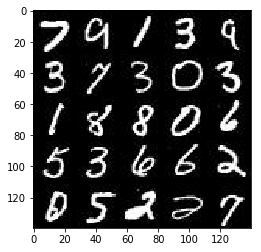

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

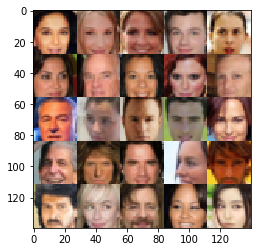

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    in_learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    return input_real, input_z, in_learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    stddev = 0.02
    alpha = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        # Layer 1 
        x1 = tf.layers.conv2d(images, 32, 5, 2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x1 = tf.maximum(alpha * x1, x1)

        # Layer 2
        x2 = tf.layers.conv2d(x1, 64, 5, 2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
         
        # Layer 3
        x3 = tf.layers.conv2d(x2, 128, 5, 2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3) 
        
        # Layer 4         
        x4 = tf.layers.conv2d(x3, 256, 5, 2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x4 = tf.layers.batch_normalization(x4, training=True)
        x4 = tf.maximum(alpha * x4, x4)
        
        flattened = tf.reshape(x4, (-1, 2*2*256))
        logits = tf.layers.dense(flattened, 1,kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        output = tf.sigmoid(logits)
        
        return output, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.1
    stddev=0.02
    with tf.variable_scope('generator', reuse=not is_train):
        
        # Layer 1
        x1 = tf.layers.dense(z, 4 * 4 * 512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        # Layer 2
        x2 = tf.layers.conv2d_transpose(x1, 128, 4, 1, padding='valid',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        # Layer 3
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, 2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Layer 4
        x4 = tf.layers.conv2d_transpose(x3, 32, 5, 2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 3, 1, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    model = generator(input_z, out_channel_dim)
    model_real, logits_real = discriminator(input_real)
    model_fake, logits_fake = discriminator(model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits= logits_real,labels=tf.ones_like(logits_real) * 0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits= logits_fake,labels=tf.zeros_like(logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits= logits_fake,labels=tf.ones_like( logits_fake)))
    
    return d_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    d_var = [var for var in train_vars if var.name.startswith('discriminator')]
    g_var = [var for var in train_vars if var.name.startswith('generator')]
    
    update = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    generator_update_ops = [op for op in update if op.name.startswith('generator')]
    
    with tf.control_dependencies(generator_update_ops):
        dis_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_var)
        gen_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_var)
    
        return dis_train_ops, gen_train_ops


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, in_learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, gen_ops = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    i = 0
    
    print_every = 10
    show_every = 100
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                i += 1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={ input_real: batch_images, input_z: batch_z, in_learning_rate: learning_rate })
                _ = sess.run(gen_ops, feed_dict={ input_z: batch_z, in_learning_rate: learning_rate })
                
                if i % print_every == 0:
                    d_loss_train = d_loss.eval({input_z: batch_z,input_real: batch_images})
                    g_loss_train = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(d_loss_train),
                          "Generator Loss: {:.4f}".format(g_loss_train))
                    
                if i % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
        saver.save(sess, './checkpoints/checkpoint.ckpt')

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5024... Generator Loss: 2.1015
Epoch 1/2... Discriminator Loss: 0.7914... Generator Loss: 2.4924
Epoch 1/2... Discriminator Loss: 1.7991... Generator Loss: 0.6634
Epoch 1/2... Discriminator Loss: 0.8972... Generator Loss: 2.1808
Epoch 1/2... Discriminator Loss: 0.9817... Generator Loss: 4.5610
Epoch 1/2... Discriminator Loss: 0.9186... Generator Loss: 1.4682
Epoch 1/2... Discriminator Loss: 0.5326... Generator Loss: 2.2632
Epoch 1/2... Discriminator Loss: 0.9799... Generator Loss: 1.0941
Epoch 1/2... Discriminator Loss: 1.2041... Generator Loss: 0.8390
Epoch 1/2... Discriminator Loss: 1.2556... Generator Loss: 0.6363


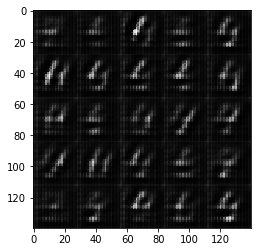

Epoch 1/2... Discriminator Loss: 0.8146... Generator Loss: 1.2673
Epoch 1/2... Discriminator Loss: 0.8017... Generator Loss: 1.5507
Epoch 1/2... Discriminator Loss: 2.1402... Generator Loss: 0.2043
Epoch 1/2... Discriminator Loss: 1.2688... Generator Loss: 4.0709
Epoch 1/2... Discriminator Loss: 1.3209... Generator Loss: 3.5924
Epoch 1/2... Discriminator Loss: 0.8746... Generator Loss: 2.3160
Epoch 1/2... Discriminator Loss: 1.6194... Generator Loss: 0.4519
Epoch 1/2... Discriminator Loss: 0.8421... Generator Loss: 1.2464
Epoch 1/2... Discriminator Loss: 0.9939... Generator Loss: 1.5337
Epoch 1/2... Discriminator Loss: 0.8353... Generator Loss: 2.3820


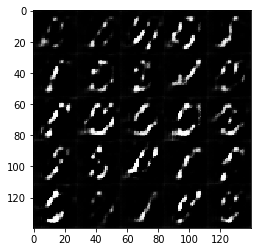

Epoch 1/2... Discriminator Loss: 1.1039... Generator Loss: 0.8131
Epoch 1/2... Discriminator Loss: 0.9023... Generator Loss: 1.1944
Epoch 1/2... Discriminator Loss: 0.8544... Generator Loss: 1.1700
Epoch 1/2... Discriminator Loss: 1.2498... Generator Loss: 0.6983
Epoch 1/2... Discriminator Loss: 0.8584... Generator Loss: 1.9724
Epoch 1/2... Discriminator Loss: 1.1782... Generator Loss: 1.7427
Epoch 1/2... Discriminator Loss: 1.1243... Generator Loss: 0.8821
Epoch 1/2... Discriminator Loss: 0.8496... Generator Loss: 1.5143
Epoch 1/2... Discriminator Loss: 1.6944... Generator Loss: 0.3586
Epoch 1/2... Discriminator Loss: 1.0614... Generator Loss: 1.7102


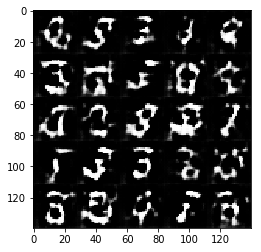

Epoch 1/2... Discriminator Loss: 1.2091... Generator Loss: 0.6649
Epoch 1/2... Discriminator Loss: 0.9697... Generator Loss: 1.0863
Epoch 1/2... Discriminator Loss: 1.2673... Generator Loss: 0.6633
Epoch 1/2... Discriminator Loss: 1.0715... Generator Loss: 0.8676
Epoch 1/2... Discriminator Loss: 0.9509... Generator Loss: 1.1996
Epoch 1/2... Discriminator Loss: 1.0608... Generator Loss: 0.8711
Epoch 1/2... Discriminator Loss: 1.0345... Generator Loss: 1.1607
Epoch 1/2... Discriminator Loss: 1.3240... Generator Loss: 0.6456
Epoch 1/2... Discriminator Loss: 1.0469... Generator Loss: 0.8517
Epoch 1/2... Discriminator Loss: 1.3286... Generator Loss: 0.6065


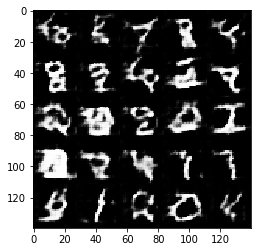

Epoch 1/2... Discriminator Loss: 1.2376... Generator Loss: 0.6536
Epoch 1/2... Discriminator Loss: 0.9193... Generator Loss: 1.1056
Epoch 1/2... Discriminator Loss: 1.0717... Generator Loss: 1.1188
Epoch 1/2... Discriminator Loss: 1.0137... Generator Loss: 0.9675
Epoch 1/2... Discriminator Loss: 1.1936... Generator Loss: 0.7038
Epoch 1/2... Discriminator Loss: 1.3732... Generator Loss: 0.5736
Epoch 1/2... Discriminator Loss: 1.2162... Generator Loss: 0.8239
Epoch 1/2... Discriminator Loss: 1.0910... Generator Loss: 0.8668
Epoch 1/2... Discriminator Loss: 1.3800... Generator Loss: 0.5333
Epoch 1/2... Discriminator Loss: 0.9399... Generator Loss: 0.9441


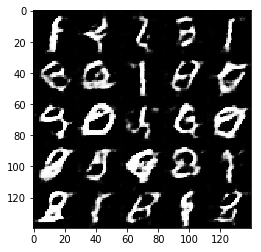

Epoch 1/2... Discriminator Loss: 0.9886... Generator Loss: 1.6157
Epoch 1/2... Discriminator Loss: 0.8359... Generator Loss: 1.2796
Epoch 1/2... Discriminator Loss: 1.3316... Generator Loss: 0.5863
Epoch 1/2... Discriminator Loss: 1.4392... Generator Loss: 0.5133
Epoch 1/2... Discriminator Loss: 1.8066... Generator Loss: 0.3351
Epoch 1/2... Discriminator Loss: 1.3206... Generator Loss: 0.5378
Epoch 1/2... Discriminator Loss: 1.1373... Generator Loss: 0.8446
Epoch 1/2... Discriminator Loss: 1.2968... Generator Loss: 1.0619
Epoch 1/2... Discriminator Loss: 1.5421... Generator Loss: 0.4054
Epoch 1/2... Discriminator Loss: 1.1695... Generator Loss: 0.9550


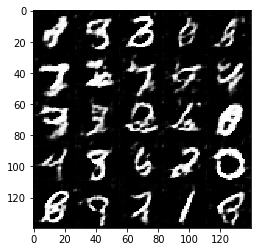

Epoch 1/2... Discriminator Loss: 1.1114... Generator Loss: 1.1853
Epoch 1/2... Discriminator Loss: 1.1112... Generator Loss: 0.7261
Epoch 1/2... Discriminator Loss: 1.2800... Generator Loss: 1.2765
Epoch 1/2... Discriminator Loss: 1.1119... Generator Loss: 0.9150
Epoch 1/2... Discriminator Loss: 1.0099... Generator Loss: 1.1562
Epoch 1/2... Discriminator Loss: 1.5386... Generator Loss: 0.4026
Epoch 1/2... Discriminator Loss: 0.8506... Generator Loss: 1.6160
Epoch 1/2... Discriminator Loss: 1.0384... Generator Loss: 0.7667
Epoch 1/2... Discriminator Loss: 1.4527... Generator Loss: 0.4625
Epoch 1/2... Discriminator Loss: 1.0645... Generator Loss: 1.7525


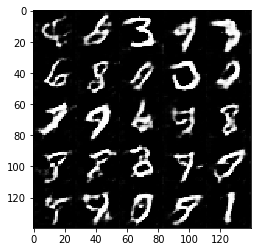

Epoch 1/2... Discriminator Loss: 1.2250... Generator Loss: 0.8797
Epoch 1/2... Discriminator Loss: 1.0401... Generator Loss: 0.8261
Epoch 1/2... Discriminator Loss: 0.9243... Generator Loss: 1.1915
Epoch 1/2... Discriminator Loss: 1.5815... Generator Loss: 0.4278
Epoch 1/2... Discriminator Loss: 1.2238... Generator Loss: 0.6399
Epoch 1/2... Discriminator Loss: 0.7746... Generator Loss: 1.3801
Epoch 1/2... Discriminator Loss: 1.1222... Generator Loss: 0.8277
Epoch 1/2... Discriminator Loss: 1.0394... Generator Loss: 0.8661
Epoch 1/2... Discriminator Loss: 1.4342... Generator Loss: 0.4746
Epoch 1/2... Discriminator Loss: 1.2442... Generator Loss: 0.6137


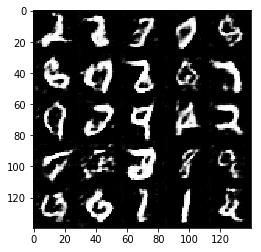

Epoch 1/2... Discriminator Loss: 1.2411... Generator Loss: 1.6108
Epoch 1/2... Discriminator Loss: 0.9042... Generator Loss: 1.6859
Epoch 1/2... Discriminator Loss: 1.0918... Generator Loss: 0.7142
Epoch 1/2... Discriminator Loss: 1.3276... Generator Loss: 0.6741
Epoch 1/2... Discriminator Loss: 1.8848... Generator Loss: 3.0424
Epoch 1/2... Discriminator Loss: 1.0608... Generator Loss: 1.5266
Epoch 1/2... Discriminator Loss: 1.0686... Generator Loss: 0.7609
Epoch 1/2... Discriminator Loss: 1.5192... Generator Loss: 0.4071
Epoch 1/2... Discriminator Loss: 1.2844... Generator Loss: 1.0427
Epoch 1/2... Discriminator Loss: 1.5868... Generator Loss: 2.2072


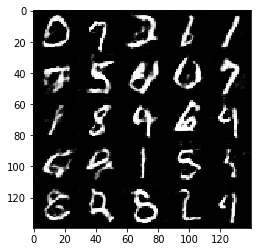

Epoch 1/2... Discriminator Loss: 1.3045... Generator Loss: 0.6377
Epoch 1/2... Discriminator Loss: 1.4642... Generator Loss: 0.6387
Epoch 1/2... Discriminator Loss: 1.0721... Generator Loss: 0.8774
Epoch 2/2... Discriminator Loss: 1.2894... Generator Loss: 0.5468
Epoch 2/2... Discriminator Loss: 1.1443... Generator Loss: 0.6929
Epoch 2/2... Discriminator Loss: 0.9499... Generator Loss: 1.5171
Epoch 2/2... Discriminator Loss: 1.4884... Generator Loss: 0.4226
Epoch 2/2... Discriminator Loss: 1.1025... Generator Loss: 0.7121
Epoch 2/2... Discriminator Loss: 1.0751... Generator Loss: 0.7885
Epoch 2/2... Discriminator Loss: 1.3343... Generator Loss: 0.4957


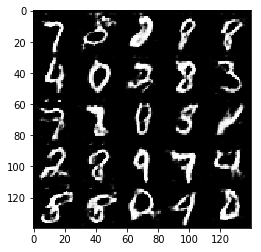

Epoch 2/2... Discriminator Loss: 1.0788... Generator Loss: 0.8441
Epoch 2/2... Discriminator Loss: 1.0141... Generator Loss: 0.9746
Epoch 2/2... Discriminator Loss: 1.2714... Generator Loss: 0.5662
Epoch 2/2... Discriminator Loss: 1.4088... Generator Loss: 0.4799
Epoch 2/2... Discriminator Loss: 1.0940... Generator Loss: 1.0859
Epoch 2/2... Discriminator Loss: 2.7561... Generator Loss: 0.1161
Epoch 2/2... Discriminator Loss: 1.4363... Generator Loss: 0.4849
Epoch 2/2... Discriminator Loss: 1.0903... Generator Loss: 1.0950
Epoch 2/2... Discriminator Loss: 1.7457... Generator Loss: 0.3239
Epoch 2/2... Discriminator Loss: 1.5766... Generator Loss: 0.4495


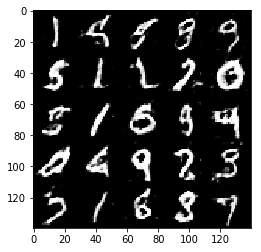

Epoch 2/2... Discriminator Loss: 1.1741... Generator Loss: 1.0835
Epoch 2/2... Discriminator Loss: 1.4071... Generator Loss: 0.5539
Epoch 2/2... Discriminator Loss: 1.4789... Generator Loss: 0.4493
Epoch 2/2... Discriminator Loss: 1.4948... Generator Loss: 0.4578
Epoch 2/2... Discriminator Loss: 1.7072... Generator Loss: 0.3299
Epoch 2/2... Discriminator Loss: 1.0545... Generator Loss: 2.0517
Epoch 2/2... Discriminator Loss: 1.2356... Generator Loss: 0.5741
Epoch 2/2... Discriminator Loss: 0.8054... Generator Loss: 1.6958
Epoch 2/2... Discriminator Loss: 1.6039... Generator Loss: 0.4065
Epoch 2/2... Discriminator Loss: 1.1143... Generator Loss: 0.8732


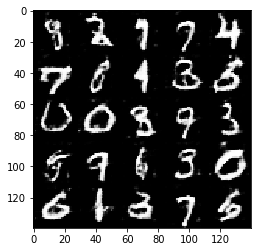

Epoch 2/2... Discriminator Loss: 0.9894... Generator Loss: 0.9090
Epoch 2/2... Discriminator Loss: 1.5323... Generator Loss: 0.3952
Epoch 2/2... Discriminator Loss: 0.9933... Generator Loss: 1.0176
Epoch 2/2... Discriminator Loss: 1.0193... Generator Loss: 1.7110
Epoch 2/2... Discriminator Loss: 1.1150... Generator Loss: 0.8772
Epoch 2/2... Discriminator Loss: 1.1448... Generator Loss: 0.6717
Epoch 2/2... Discriminator Loss: 1.1306... Generator Loss: 0.7025
Epoch 2/2... Discriminator Loss: 1.2293... Generator Loss: 0.5844
Epoch 2/2... Discriminator Loss: 1.5112... Generator Loss: 0.4679
Epoch 2/2... Discriminator Loss: 1.0650... Generator Loss: 1.8376


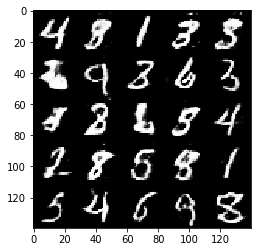

Epoch 2/2... Discriminator Loss: 1.7090... Generator Loss: 0.3346
Epoch 2/2... Discriminator Loss: 1.2270... Generator Loss: 0.8163
Epoch 2/2... Discriminator Loss: 1.1363... Generator Loss: 0.7592
Epoch 2/2... Discriminator Loss: 0.9948... Generator Loss: 1.5662
Epoch 2/2... Discriminator Loss: 1.5577... Generator Loss: 2.2050
Epoch 2/2... Discriminator Loss: 1.1435... Generator Loss: 0.6515
Epoch 2/2... Discriminator Loss: 1.6557... Generator Loss: 0.3842
Epoch 2/2... Discriminator Loss: 1.2049... Generator Loss: 1.3362
Epoch 2/2... Discriminator Loss: 1.6720... Generator Loss: 0.3765
Epoch 2/2... Discriminator Loss: 2.1903... Generator Loss: 0.1900


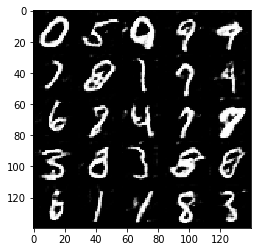

Epoch 2/2... Discriminator Loss: 1.0370... Generator Loss: 1.1038
Epoch 2/2... Discriminator Loss: 1.3090... Generator Loss: 0.5247
Epoch 2/2... Discriminator Loss: 1.9984... Generator Loss: 0.2428
Epoch 2/2... Discriminator Loss: 1.9267... Generator Loss: 0.2624
Epoch 2/2... Discriminator Loss: 1.1582... Generator Loss: 1.1345
Epoch 2/2... Discriminator Loss: 0.9312... Generator Loss: 0.9520
Epoch 2/2... Discriminator Loss: 1.9026... Generator Loss: 0.3475
Epoch 2/2... Discriminator Loss: 0.8965... Generator Loss: 1.6435
Epoch 2/2... Discriminator Loss: 1.6953... Generator Loss: 0.4277
Epoch 2/2... Discriminator Loss: 1.2106... Generator Loss: 0.6934


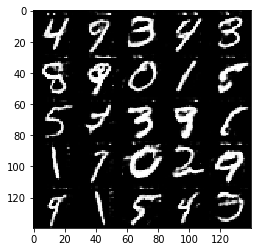

Epoch 2/2... Discriminator Loss: 1.8510... Generator Loss: 0.3692
Epoch 2/2... Discriminator Loss: 1.5310... Generator Loss: 0.4083
Epoch 2/2... Discriminator Loss: 1.4038... Generator Loss: 0.5001
Epoch 2/2... Discriminator Loss: 1.3063... Generator Loss: 0.7021
Epoch 2/2... Discriminator Loss: 1.4116... Generator Loss: 0.5425
Epoch 2/2... Discriminator Loss: 1.6259... Generator Loss: 0.3648
Epoch 2/2... Discriminator Loss: 1.2809... Generator Loss: 0.5983
Epoch 2/2... Discriminator Loss: 1.0656... Generator Loss: 0.7581
Epoch 2/2... Discriminator Loss: 1.1240... Generator Loss: 1.0868
Epoch 2/2... Discriminator Loss: 1.6822... Generator Loss: 2.7681


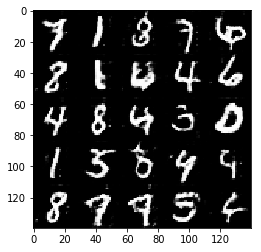

Epoch 2/2... Discriminator Loss: 1.3548... Generator Loss: 0.5213
Epoch 2/2... Discriminator Loss: 1.6346... Generator Loss: 0.5047
Epoch 2/2... Discriminator Loss: 1.1266... Generator Loss: 0.7264
Epoch 2/2... Discriminator Loss: 2.1449... Generator Loss: 0.2037
Epoch 2/2... Discriminator Loss: 1.1834... Generator Loss: 0.7112
Epoch 2/2... Discriminator Loss: 1.2559... Generator Loss: 1.0504
Epoch 2/2... Discriminator Loss: 1.8807... Generator Loss: 0.2915
Epoch 2/2... Discriminator Loss: 1.3456... Generator Loss: 0.5355
Epoch 2/2... Discriminator Loss: 1.0353... Generator Loss: 0.9454
Epoch 2/2... Discriminator Loss: 1.5429... Generator Loss: 0.4099


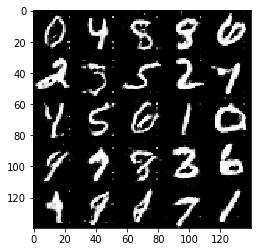

Epoch 2/2... Discriminator Loss: 2.2536... Generator Loss: 0.1947
Epoch 2/2... Discriminator Loss: 1.9089... Generator Loss: 0.3776
Epoch 2/2... Discriminator Loss: 1.0950... Generator Loss: 0.6937
Epoch 2/2... Discriminator Loss: 1.0317... Generator Loss: 1.3917
Epoch 2/2... Discriminator Loss: 1.4249... Generator Loss: 0.4961
Epoch 2/2... Discriminator Loss: 1.2492... Generator Loss: 0.7304
Epoch 2/2... Discriminator Loss: 1.6560... Generator Loss: 0.3510
Epoch 2/2... Discriminator Loss: 2.3739... Generator Loss: 0.1786
Epoch 2/2... Discriminator Loss: 1.9875... Generator Loss: 0.2529
Epoch 2/2... Discriminator Loss: 1.2086... Generator Loss: 2.0638


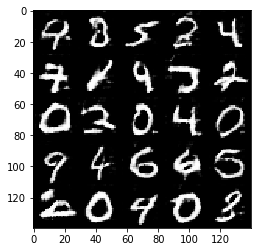

Epoch 2/2... Discriminator Loss: 1.1608... Generator Loss: 0.9564
Epoch 2/2... Discriminator Loss: 1.9211... Generator Loss: 0.2607
Epoch 2/2... Discriminator Loss: 1.5341... Generator Loss: 0.3909
Epoch 2/2... Discriminator Loss: 1.0667... Generator Loss: 0.9236
Epoch 2/2... Discriminator Loss: 1.2053... Generator Loss: 0.7778
Epoch 2/2... Discriminator Loss: 1.4529... Generator Loss: 1.7981
Epoch 2/2... Discriminator Loss: 1.6623... Generator Loss: 0.3482


In [ ]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8761... Generator Loss: 1.1831
Epoch 1/1... Discriminator Loss: 0.7683... Generator Loss: 1.4327
Epoch 1/1... Discriminator Loss: 0.7232... Generator Loss: 1.5293
Epoch 1/1... Discriminator Loss: 0.6402... Generator Loss: 1.7275
Epoch 1/1... Discriminator Loss: 0.6173... Generator Loss: 1.8080
Epoch 1/1... Discriminator Loss: 0.5444... Generator Loss: 2.1694
Epoch 1/1... Discriminator Loss: 0.5564... Generator Loss: 2.1279
Epoch 1/1... Discriminator Loss: 0.6087... Generator Loss: 1.7833
Epoch 1/1... Discriminator Loss: 0.4690... Generator Loss: 2.5931
Epoch 1/1... Discriminator Loss: 0.4103... Generator Loss: 3.5333


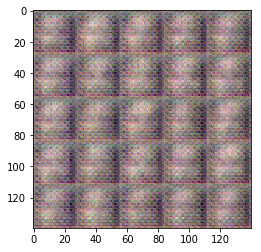

Epoch 1/1... Discriminator Loss: 0.6561... Generator Loss: 1.6537
Epoch 1/1... Discriminator Loss: 0.7065... Generator Loss: 1.3772
Epoch 1/1... Discriminator Loss: 0.9466... Generator Loss: 1.3975
Epoch 1/1... Discriminator Loss: 0.7179... Generator Loss: 1.6436
Epoch 1/1... Discriminator Loss: 1.2378... Generator Loss: 3.1995
Epoch 1/1... Discriminator Loss: 0.8561... Generator Loss: 1.5767
Epoch 1/1... Discriminator Loss: 0.6157... Generator Loss: 2.0202
Epoch 1/1... Discriminator Loss: 0.6751... Generator Loss: 1.8588
Epoch 1/1... Discriminator Loss: 0.7047... Generator Loss: 1.8858
Epoch 1/1... Discriminator Loss: 0.8116... Generator Loss: 1.9548


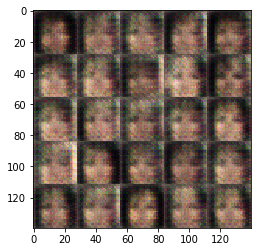

Epoch 1/1... Discriminator Loss: 0.8920... Generator Loss: 1.7087
Epoch 1/1... Discriminator Loss: 0.7927... Generator Loss: 1.2594
Epoch 1/1... Discriminator Loss: 0.9597... Generator Loss: 1.4735
Epoch 1/1... Discriminator Loss: 0.8653... Generator Loss: 1.4140
Epoch 1/1... Discriminator Loss: 0.7351... Generator Loss: 1.7738
Epoch 1/1... Discriminator Loss: 0.8914... Generator Loss: 2.1731
Epoch 1/1... Discriminator Loss: 0.7951... Generator Loss: 1.4897
Epoch 1/1... Discriminator Loss: 0.7646... Generator Loss: 1.6569
Epoch 1/1... Discriminator Loss: 0.8506... Generator Loss: 2.6387
Epoch 1/1... Discriminator Loss: 1.0708... Generator Loss: 1.0903


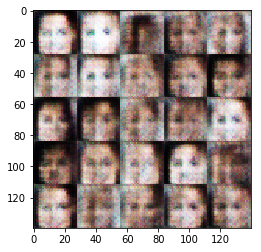

Epoch 1/1... Discriminator Loss: 0.6822... Generator Loss: 2.0504
Epoch 1/1... Discriminator Loss: 0.6660... Generator Loss: 1.6698
Epoch 1/1... Discriminator Loss: 0.7424... Generator Loss: 1.6841
Epoch 1/1... Discriminator Loss: 0.8401... Generator Loss: 1.2689
Epoch 1/1... Discriminator Loss: 0.8678... Generator Loss: 1.6317
Epoch 1/1... Discriminator Loss: 0.7542... Generator Loss: 1.8167
Epoch 1/1... Discriminator Loss: 0.9333... Generator Loss: 1.3567
Epoch 1/1... Discriminator Loss: 0.9068... Generator Loss: 3.1576
Epoch 1/1... Discriminator Loss: 0.9371... Generator Loss: 1.3448
Epoch 1/1... Discriminator Loss: 0.9994... Generator Loss: 0.9898


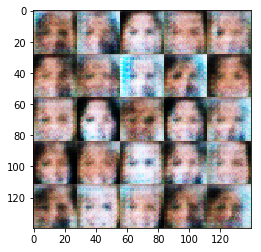

Epoch 1/1... Discriminator Loss: 1.0864... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 0.8372... Generator Loss: 1.5961
Epoch 1/1... Discriminator Loss: 0.7958... Generator Loss: 2.3434
Epoch 1/1... Discriminator Loss: 1.0043... Generator Loss: 2.8051
Epoch 1/1... Discriminator Loss: 0.9246... Generator Loss: 1.7436
Epoch 1/1... Discriminator Loss: 0.6867... Generator Loss: 1.6891
Epoch 1/1... Discriminator Loss: 0.7873... Generator Loss: 1.2738
Epoch 1/1... Discriminator Loss: 0.5746... Generator Loss: 2.2765
Epoch 1/1... Discriminator Loss: 0.7884... Generator Loss: 1.2896
Epoch 1/1... Discriminator Loss: 0.7273... Generator Loss: 1.7013


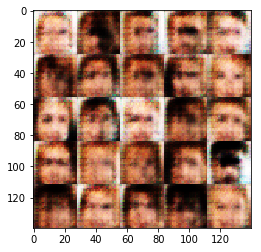

Epoch 1/1... Discriminator Loss: 0.5424... Generator Loss: 2.1918
Epoch 1/1... Discriminator Loss: 0.9298... Generator Loss: 3.0870
Epoch 1/1... Discriminator Loss: 0.9382... Generator Loss: 1.1702
Epoch 1/1... Discriminator Loss: 0.7258... Generator Loss: 1.9963
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 2.5958
Epoch 1/1... Discriminator Loss: 0.8916... Generator Loss: 1.7909
Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 1.8021
Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 0.8948
Epoch 1/1... Discriminator Loss: 0.9993... Generator Loss: 1.0136
Epoch 1/1... Discriminator Loss: 0.8704... Generator Loss: 2.0977


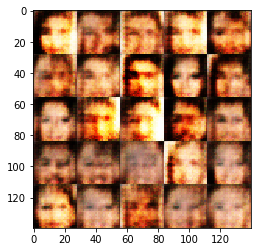

Epoch 1/1... Discriminator Loss: 1.0176... Generator Loss: 1.0187
Epoch 1/1... Discriminator Loss: 0.9784... Generator Loss: 1.2453
Epoch 1/1... Discriminator Loss: 0.8259... Generator Loss: 1.4344
Epoch 1/1... Discriminator Loss: 1.0606... Generator Loss: 1.8587
Epoch 1/1... Discriminator Loss: 0.8848... Generator Loss: 1.9265
Epoch 1/1... Discriminator Loss: 0.8001... Generator Loss: 1.2806
Epoch 1/1... Discriminator Loss: 0.5844... Generator Loss: 2.1225
Epoch 1/1... Discriminator Loss: 0.6107... Generator Loss: 2.1696
Epoch 1/1... Discriminator Loss: 0.6918... Generator Loss: 1.6572
Epoch 1/1... Discriminator Loss: 0.8133... Generator Loss: 3.2297


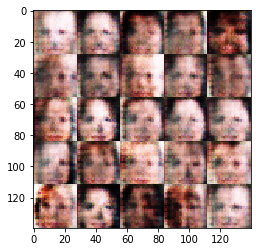

Epoch 1/1... Discriminator Loss: 0.8229... Generator Loss: 1.3322
Epoch 1/1... Discriminator Loss: 0.8141... Generator Loss: 1.3453
Epoch 1/1... Discriminator Loss: 0.8803... Generator Loss: 1.1493
Epoch 1/1... Discriminator Loss: 1.0748... Generator Loss: 1.0011
Epoch 1/1... Discriminator Loss: 0.7609... Generator Loss: 1.6060
Epoch 1/1... Discriminator Loss: 0.8488... Generator Loss: 1.1866
Epoch 1/1... Discriminator Loss: 0.7077... Generator Loss: 2.3147
Epoch 1/1... Discriminator Loss: 0.8415... Generator Loss: 1.5754
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.1200... Generator Loss: 1.0790


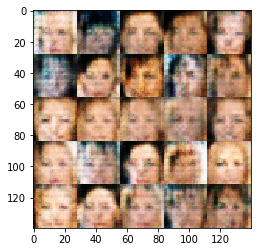

Epoch 1/1... Discriminator Loss: 1.1233... Generator Loss: 0.8688
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 1.0430
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.0050... Generator Loss: 1.6042
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 0.9007
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 0.9190
Epoch 1/1... Discriminator Loss: 0.9344... Generator Loss: 1.1087
Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 0.8840
Epoch 1/1... Discriminator Loss: 0.9352... Generator Loss: 1.2648


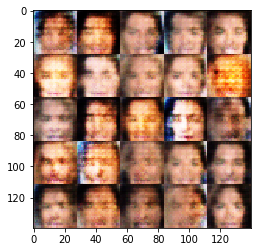

Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 1.3622
Epoch 1/1... Discriminator Loss: 0.9442... Generator Loss: 1.5993
Epoch 1/1... Discriminator Loss: 1.0573... Generator Loss: 1.1666
Epoch 1/1... Discriminator Loss: 1.0321... Generator Loss: 1.2976
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 1.3088
Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 1.0533
Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 0.8748
Epoch 1/1... Discriminator Loss: 1.0530... Generator Loss: 1.0661
Epoch 1/1... Discriminator Loss: 1.1146... Generator Loss: 0.9769


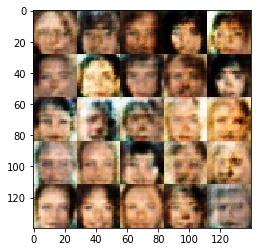

Epoch 1/1... Discriminator Loss: 0.9387... Generator Loss: 1.3308
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 0.9851... Generator Loss: 1.1594
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.5920
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 0.9551... Generator Loss: 1.0987
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 0.8835
Epoch 1/1... Discriminator Loss: 1.0887... Generator Loss: 0.9526
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 0.9017


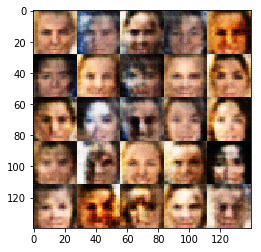

Epoch 1/1... Discriminator Loss: 1.0888... Generator Loss: 1.1500
Epoch 1/1... Discriminator Loss: 1.0939... Generator Loss: 1.1326
Epoch 1/1... Discriminator Loss: 1.0082... Generator Loss: 1.3347
Epoch 1/1... Discriminator Loss: 0.8622... Generator Loss: 1.6309
Epoch 1/1... Discriminator Loss: 0.8840... Generator Loss: 1.7258
Epoch 1/1... Discriminator Loss: 0.8539... Generator Loss: 1.4817
Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 1.1821
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 1.1398
Epoch 1/1... Discriminator Loss: 0.7555... Generator Loss: 1.7188
Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 0.8447


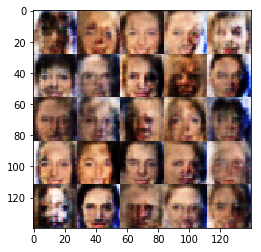

Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.0446... Generator Loss: 1.1082
Epoch 1/1... Discriminator Loss: 0.9856... Generator Loss: 1.1917
Epoch 1/1... Discriminator Loss: 0.7819... Generator Loss: 1.3782
Epoch 1/1... Discriminator Loss: 1.0446... Generator Loss: 0.9288
Epoch 1/1... Discriminator Loss: 1.0515... Generator Loss: 1.2505
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 1.0602
Epoch 1/1... Discriminator Loss: 0.9899... Generator Loss: 1.2773
Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 1.0428


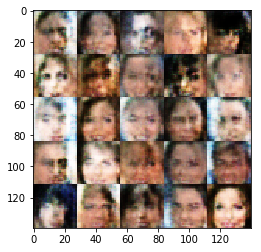

Epoch 1/1... Discriminator Loss: 0.9508... Generator Loss: 1.1151
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.8374
Epoch 1/1... Discriminator Loss: 0.7752... Generator Loss: 1.6451
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.5244
Epoch 1/1... Discriminator Loss: 1.1238... Generator Loss: 0.8636
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 1.1670
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 1.4777
Epoch 1/1... Discriminator Loss: 1.0307... Generator Loss: 1.0236
Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 0.8690
Epoch 1/1... Discriminator Loss: 0.9017... Generator Loss: 1.1586


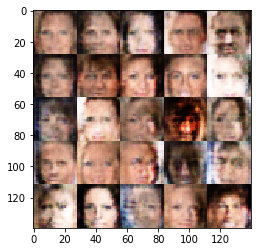

Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 0.9969
Epoch 1/1... Discriminator Loss: 0.9713... Generator Loss: 1.3591
Epoch 1/1... Discriminator Loss: 1.0484... Generator Loss: 0.9035
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 1.0951
Epoch 1/1... Discriminator Loss: 1.1033... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.0044... Generator Loss: 0.9229
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 0.9528... Generator Loss: 1.1964
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 1.0190


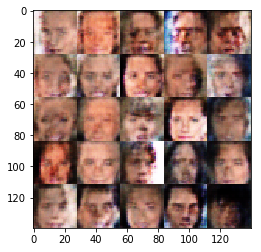

Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.0610... Generator Loss: 1.0939
Epoch 1/1... Discriminator Loss: 0.9693... Generator Loss: 1.4750
Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 1.0657
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 1.1367
Epoch 1/1... Discriminator Loss: 0.9867... Generator Loss: 1.2509


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.